# xgboost特点

GBDT中第n颗树训练时，需要用到第n-1颗树的（近似）残差。从这个角度来看，gbdt比较难以实现分布式。而xgboost从下面这个角度着手 

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/976af33a2e3af5d96a8a56e6b7878bfa.png)

注：红色箭头指向的$l$即为损失函数；红色方框为正则项，包括L1、L2；红色圆圈为常数项。 

利用泰勒展开三项，做一个近似，我们可以很清晰地看到，最终的目标函数只依赖于每个数据点的在误差函数上的一阶导数和二阶导数。


**（1）定义树的复杂度** 

对于$f$的定义做一下细化，把树拆分成结构部分$q$和叶子权重部分$w$。

下图是一个具体的例子。结构函数$q$把输入映射到叶子的索引号上面去，而$w$给定了每个索引号对应的叶子分数是什么。

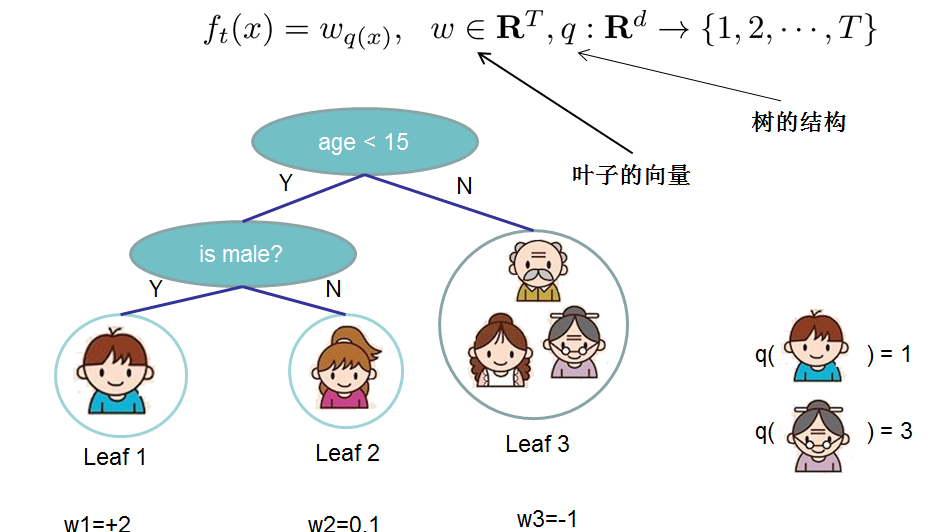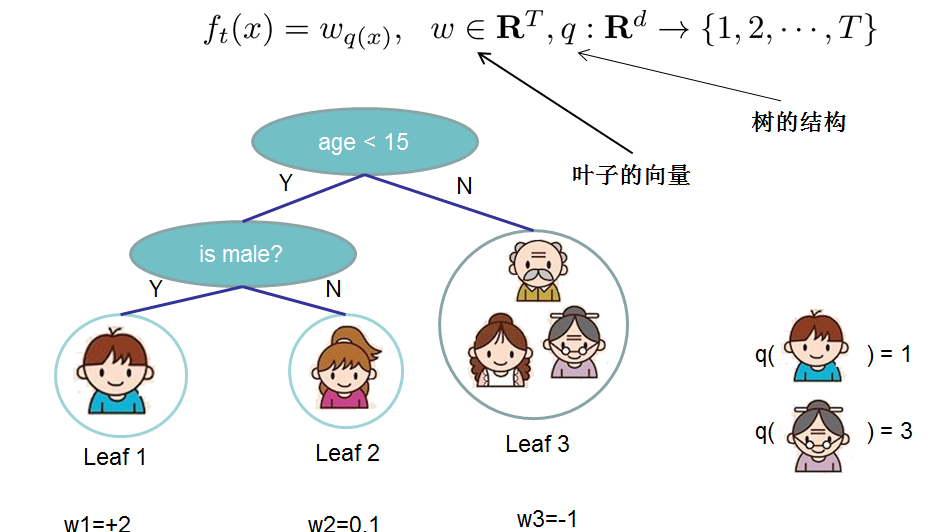

定义这个复杂度包含了一棵树里面节点的个数，以及每个树叶子节点上面输出分数的L2模平方。

当然这不是唯一的一种定义方式，不过这一定义方式学习出的树效果一般都比较不错。下图还给出了复杂度计算的一个例子。

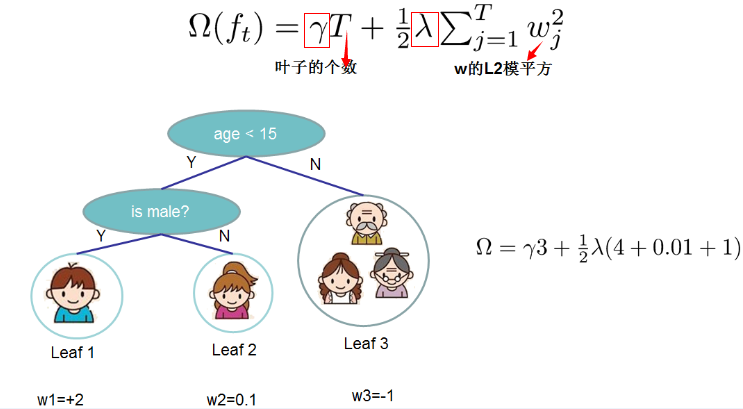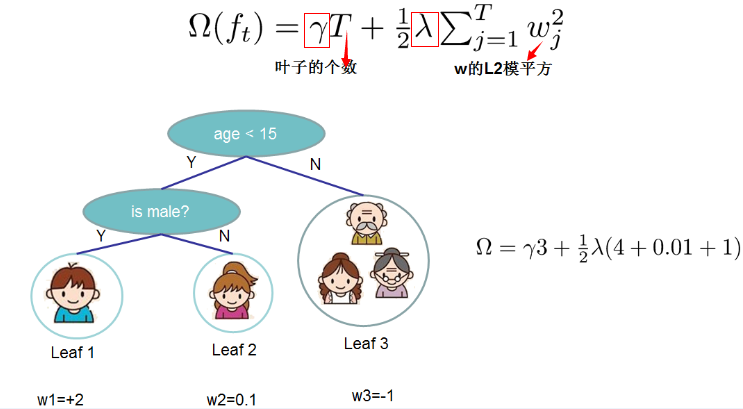

注：方框部分在最终的模型公式中控制这部分的比重,对应模型参数中的lambda ，gamma

在这种新的定义下，我们可以把目标函数进行如下改写，其中$I$被定义为每个叶子上面样本集合$I_j=\{i|q(x_i)=j\}$，g是一阶导数，h是二阶导数

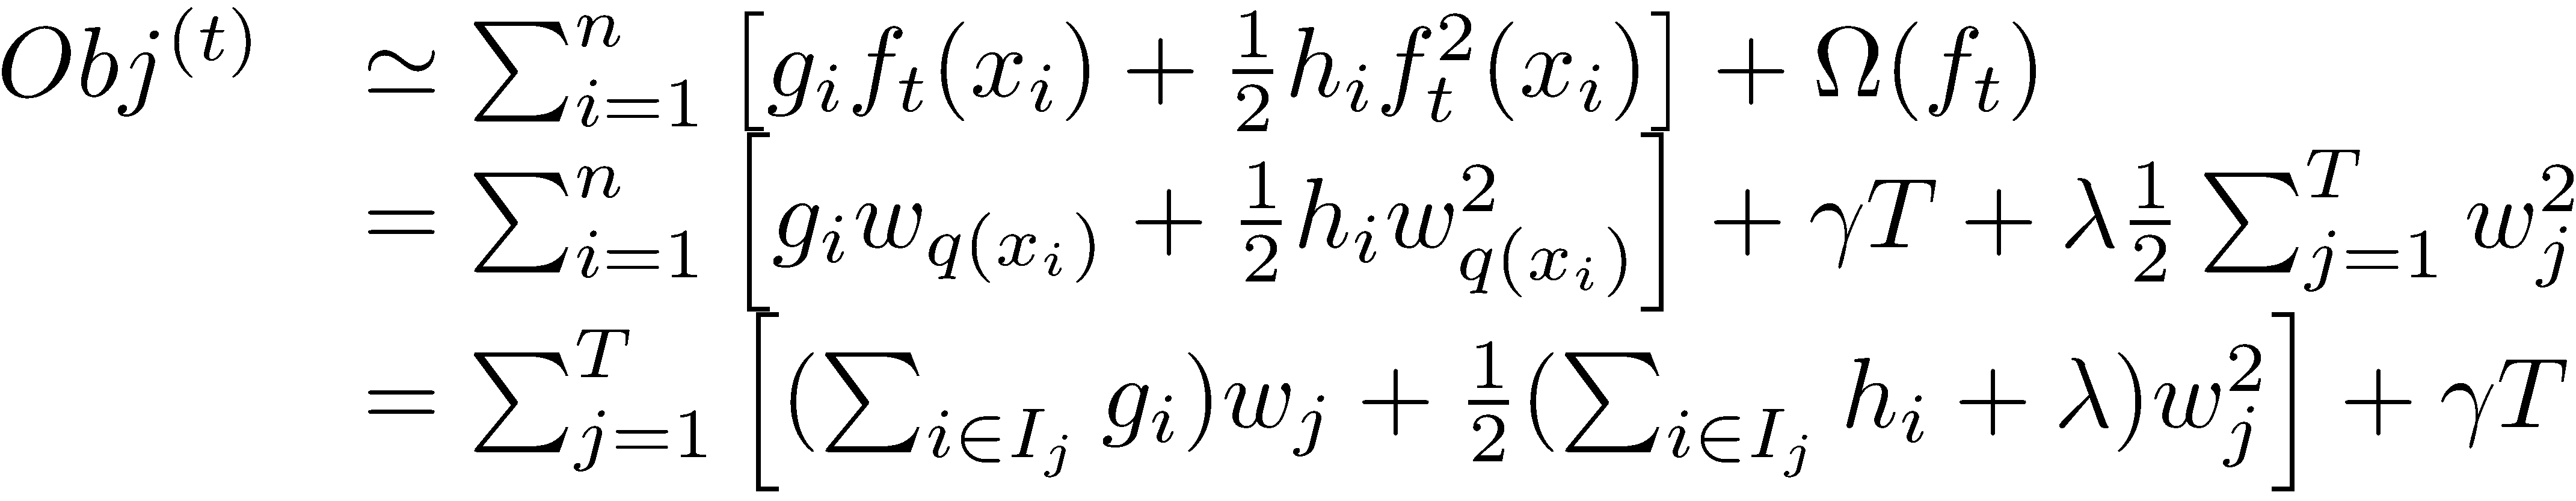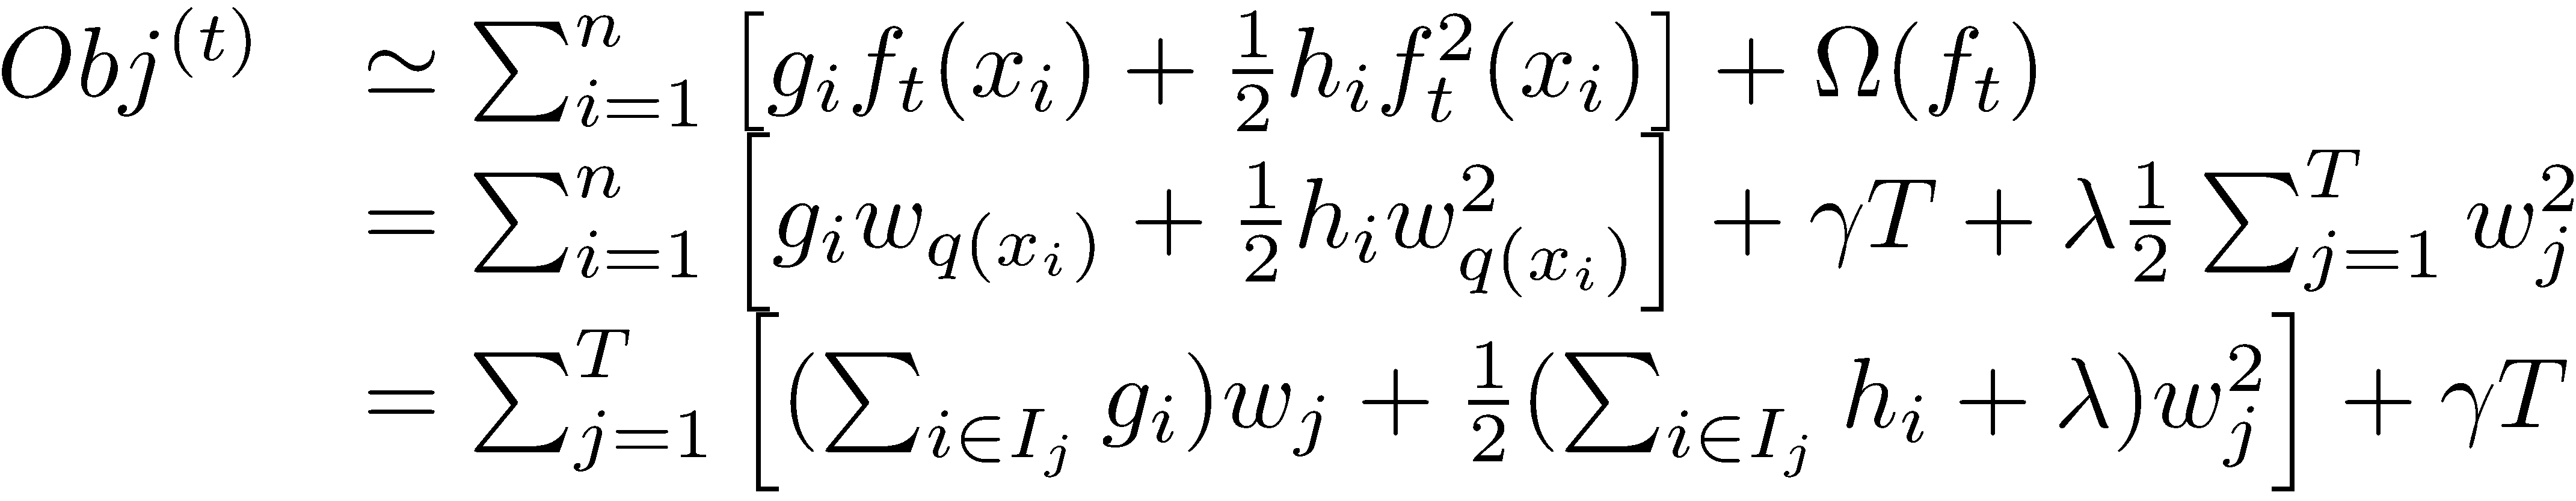

这一个目标包含了T个相互独立的单变量二次函数。我们可以定义

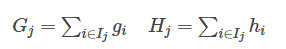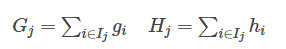

最终公式可以化简为

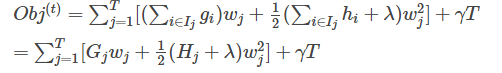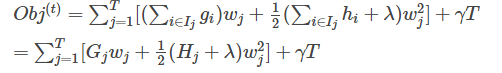

通过对$w_j$求导等于0，可以得到

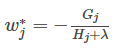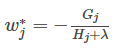

然后把$w_j$最优解代入得到：

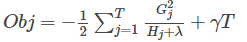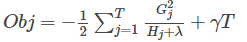


**（2）打分函数计算示例**

Obj代表了当我们指定一个树的结构的时候，我们在目标上面最多减少多少。

我们可以把它叫做结构分数(structure score)

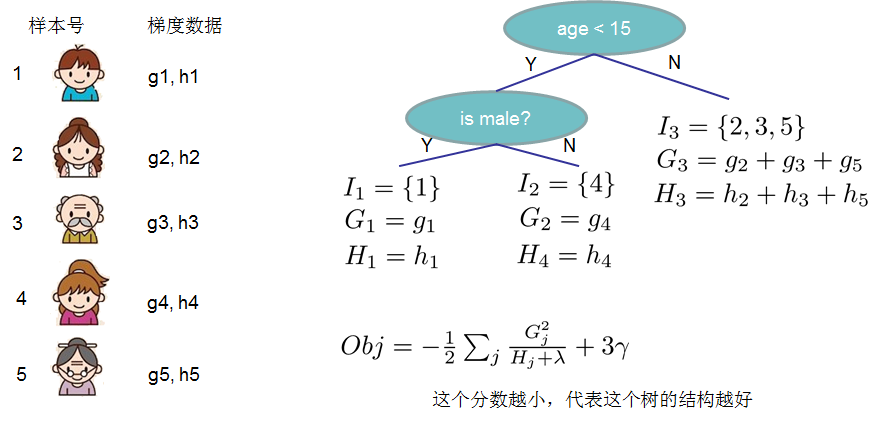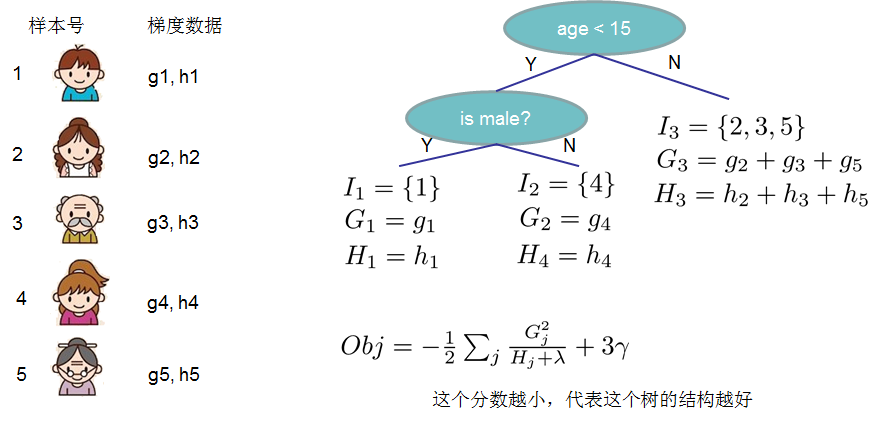


**（3）分裂节点**

论文中给出了两种分裂节点的方法

（1）贪心法：

每一次尝试都对已有的叶子加入一个分割

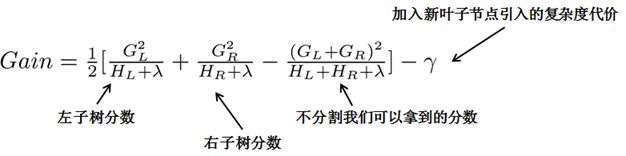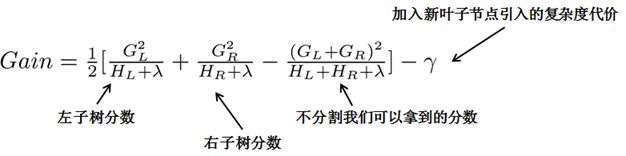

对于每次扩展，我们还是要枚举所有可能的分割方案，如何高效地枚举所有的分割呢？

我假设我们要枚举所有x < a 这样的条件，对于某个特定的分割a我们要计算a左边和右边的导数和。

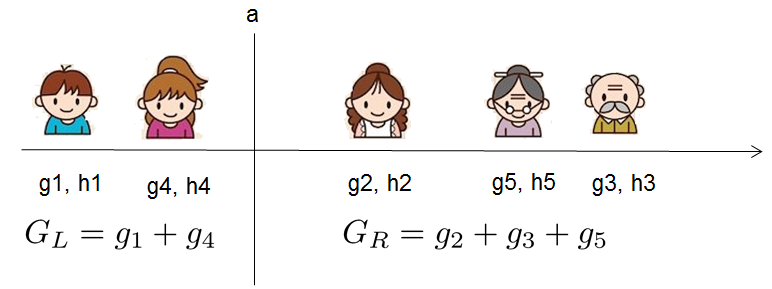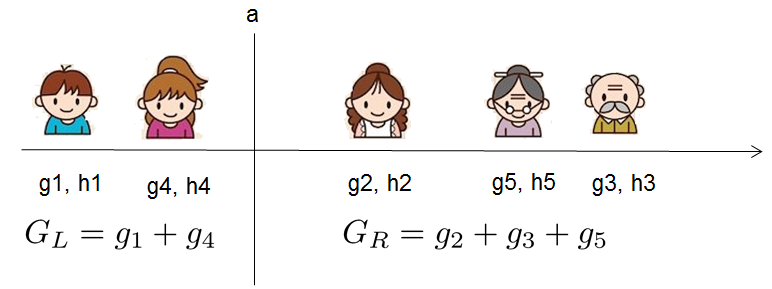

我们可以发现对于所有的a，我们只要做一遍从左到右的扫描就可以枚举出所有分割的梯度和GL和GR。

然后用上面的公式计算每个分割方案的分数就可以了。

观察这个目标函数，大家会发现第二个值得注意的事情就是引入分割不一定会使得情况变好，因为我们有一个引入新叶子的惩罚项。优化这个目标对应了树的剪枝， 当引入的分割带来的增益小于一个阀值的时候，我们可以剪掉这个分割。

大家可以发现，当我们正式地推导目标的时候，像计算分数和剪枝这样的策略都会自然地出现，而不再是一种因为heuristic（启发式）而进行的操作了。


# xgboost对比gbdt


1.传统GBDT以CART作为基分类器，xgboost还支持线性分类器，这个时候xgboost相当于带L1和L2正则化项的逻辑斯蒂回归（分类问题）或者线性回归（回归问题）。 

2.传统GBDT在优化时只用到一阶导数信息，xgboost则对代价函数进行了二阶泰勒展开，同时用到了一阶和二阶导数。顺便提一下，xgboost工具支持自定义代价函数，只要函数可一阶和二阶求导。

3.xgboost在代价函数里加入了正则项，用于控制模型的复杂度。正则项里包含了树的叶子节点个数、每个叶子节点上输出的score的L2模的平方和。从Bias-variance tradeoff角度来讲，正则项降低了模型variance，使学习出来的模型更加简单，防止过拟合，这也是xgboost优于传统GBDT的一个特性 

4、Shrinkage（缩减），相当于学习速率（xgboost中的eta）。xgboost在进行完一次迭代后，会将叶子节点的权重乘上该系数，主要是为了削弱每棵树的影响，让后面有更大的学习空间。实际应用中，一般把eta设置得小一点，然后迭代次数设置得大一点。（补充：传统GBDT的实现也有学习速率）

5、列抽样（column subsampling）。xgboost借鉴了随机森林的做法，支持列抽样，不仅能降低过拟合，还能减少计算，这也是xgboost异于传统gbdt的一个特性。

6、对缺失值的处理。对于特征的值有缺失的样本，xgboost可以自动学习出它的分裂方向。

7、xgboost工具支持并行。boosting不是一种串行的结构吗?怎么并行的？注意xgboost的并行不是tree粒度的并行，xgboost也是一次迭代完才能进行下一次迭代的（第t次迭代的代价函数里包含了前面t-1次迭代的预测值）。

xgboost的并行是在特征粒度上的。我们知道，决策树的学习最耗时的一个步骤就是对特征的值进行排序（因为要确定最佳分割点），xgboost在训练之前，预先对数据进行了排序，然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。

这个block结构也使得并行成为了可能，在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。

8、可并行的近似直方图算法。树节点在进行分裂时，我们需要计算每个特征的每个分割点对应的增益，即用贪心法枚举所有可能的分割点。当数据无法一次载入内存或者在分布式情况下，贪心算法效率就会变得很低，所以xgboost还提出了一种可并行的近似直方图算法，用于高效地生成候选的分割点。